In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Read the data
### Placeholder datafunction
data_path = 'ME.data'
#data_path = 'LC.data'
#data_path = 'ME.data'
data_set = pd.read_csv(data_path, delimiter=' ', na_values='NaN', header=None, skiprows=2)

MAKING OF THE STRUCT/DICTIONARY


In [14]:
header_start = data_set.shape[1]-2
label_names = ['participant', 'phase']

compnames = ["Time", "Intensity [Watts]", "Heart Rate [bpm]", "Ventilation [l/min]", "VO2 [ml/min]", 
             "VCO2 [ml/min]", "PetCO2 [mmHg]", "PetO2 [mmHg]", "VO2/kg [ml/min/kg]", "Ventilation / VO2", 
             "Ventialtion / VCO2", "Respiratory Quotient", "Tidal Volume [l]", "Breathing Frequency [bpm]", 
             "Inspiratory Time [s]", "Expriratory Time [s]"]
data = { "type": "som_data", "data": data_set.iloc[:,0:header_start], "labels":data_set.iloc[:,header_start:data_set.shape[1]],
        "comp_names": compnames, "comp_norm": [], "label_names": label_names,}

ID = data['labels'].iloc[:,0].unique()
phase = data['labels'].iloc[:,1].unique()
data['labels'].columns = label_names
data['data'].columns = compnames

FUNCTIONS + CLEANING


In [15]:
def get_start_end_indices(data, ID):
    start_test = data['labels'].groupby('participant').head(1).index.tolist()
    end_test = start_test[1:] + [len(data['labels'])]
    return start_test, end_test
start_test, end_test = get_start_end_indices(data, ID)

def correct_end_position(end_test):
    end_test_c = [x-1 for x in end_test]
    end_test_c[-1] =end_test_c[-1]+1
    return end_test_c


mash = data['labels'].copy()
masha = mash[mash['phase'] != 'NONE']
data['labels'] = masha

MAKING BREATH TIMES

In [16]:
MIN = []
MAX = []
breath_time = []
for i in range(len(ID)):
    start = start_test[i]
    end = end_test[i]
    bt = np.diff(data['data'].iloc[start:end, 0].to_numpy(), prepend=0)
    #bt[bt < -100] = np.nan
    breath_time.append(bt)
    MIN.append(np.nanmin(bt))
    MAX.append(np.nanmax(bt))

breath_data = data['data'].iloc[:,0]
data['data'].iloc[:,0] = pd.Series(np.concatenate(breath_time))
end_test_c = correct_end_position(end_test)

FIND TRIAL PHASES FOR EACH PARTICIPANT

In [17]:
start_exercise = []
end_exercise = []

for i in range(len(ID)):
    ip = data['labels'][start_test[i]:end_test_c[i]].groupby('phase').head(1)
    start_exercise.append(ip[ip['phase'] == 'EXERCISE'].index[0])
    end_exercise.append((data['labels'][start_test[i]:end_test_c[i]]['phase'] == 'EXERCISE').index[-1])

CREATE A STRUCT FOR EXERCISE PART OF TRIALS

In [18]:
exercise_cell = [data['data'].iloc[start_exercise[i]:end_exercise[i]].to_numpy() for i in range(len(ID))]
labels_exercise = [np.repeat(ID[i], len(exercise_cell[i])) for i in range(len(ID))]

allLabels = np.concatenate(labels_exercise)
data_exercise_df_lab = pd.DataFrame({'participant': allLabels})
data_exercise_df_data = pd.DataFrame(np.vstack(exercise_cell), columns = compnames)
data_exercise_df = pd.concat([data_exercise_df_data, data_exercise_df_lab], axis=1)
data_exercise = {"type":data["type"], "data": data_exercise_df.iloc[:,0:16], "labels": data_exercise_df.iloc[:,16],
"comp_names": data["comp_names"], "comp_norm": [], "label_names": data["label_names"]}
data_exercise['labels'] = pd.DataFrame(data_exercise['labels'], columns = ['participant'])
start_test_exercise, end_test_exercise = get_start_end_indices(data_exercise, ID)


CHANGES IN WATTS


In [19]:
### individualize
if data_path == 'Controls.data':
    dif_data = [np.diff(data_exercise['data'].iloc[start_test_exercise[i]:end_test_exercise[i], 1]) for i in range(len(ID))]
elif data_path == 'LC.data':
    dif_data = [np.diff(data_exercise['data'].iloc[start_test_exercise[i]:end_test_exercise[i], 1]) for i in range(len(ID))]
elif data_path == 'ME.data':
    dif_data = [np.diff(data_exercise['data'].iloc[start_test_exercise[i]:end_test_exercise[i], 1]) for i in range(len(ID))]

NORMALIZE DATA

In [20]:
differences = []
max_diff = 0
trial_length1 = data_exercise['labels'].groupby('participant').head(1).index.tolist()
for i in range(len(trial_length1)):
       if i < len(trial_length1)-1:
               diff = trial_length1[i+1] - trial_length1[i]
               differences.append(diff)
       if i == len(trial_length1)-1:
               diff = len(data_exercise['labels']) - trial_length1[i]
               differences.append(diff)
       if diff > max_diff:
            max_diff = diff
            max_diff_index = i

#Normalised based on Duration of trial, Because starting resistance differed between trials  
diff_normalised = [max_diff/difference for difference in differences]
data_normalized = [data_exercise['data'].iloc[start_test_exercise[i]:end_test_exercise[i]].apply(lambda x: x * diff_normalised[i], axis=1).to_numpy() for i in range(len(ID))]

data_cell = []
for i in range(len(differences)):
        trial_matrix = np.full((max_diff, data_exercise['data'].shape[1]), np.nan)
        data_cell.append(0)
        trial_matrix[:differences[i], :data_exercise['data'].shape[1]] = data_normalized[i]
        data_cell[i] = trial_matrix

data_cell_v = np.vstack(data_cell)
data_cell_df = pd.DataFrame(data_cell_v)

data_normalized = {"type":data["type"], "data": data_cell_df, "labels": np.repeat(ID, max_diff), "comp_names": data_exercise["comp_names"], "comp_norm": data_exercise["comp_norm"], "label_names": data_exercise["label_names"]}
data_normalized['labels'] = pd.DataFrame(data_normalized['labels'], columns = ['participant'])
data_normalized['data'].columns = compnames

Construct breath number index

In [21]:
breath_nr = np.concatenate([np.arange(1, end_test_exercise[i] - start_test_exercise[i] + 2) for i in range(len(ID))])

SEPARATE TARGET VARIABLE FROM DATA

In [22]:
WATTS = data_normalized['data']['Intensity [Watts]']
data_normalized['data'].drop(columns=['Time', 'Intensity [Watts]'], inplace=True)


In [23]:
if data_path == 'LC.data':
    datapoints_LC = len(data_normalized['labels'])
    LC_data = data_normalized['data'].copy()
    LC_labels = data_normalized['labels'].copy()
    LC_dict = {"type":data_normalized["type"], "data": LC_data, "labels": LC_labels, "comp_names": data_normalized["comp_names"], "comp_norm": data_normalized["comp_norm"], "label_names": data_normalized["label_names"]}
    LC_dict['labels'] = pd.DataFrame(LC_dict['labels'], columns = ['participant'])
    LC_dict['data'].columns = compnames[2:]

if data_path == 'Controls.data':
    datapoints_controls = len(data_normalized['labels'])
    Control_data = data_normalized['data'].copy()
    Control_labels = data_normalized['labels'].copy()
    Control_dict = {"type":data_normalized["type"], "data": Control_data, "labels": Control_labels, "comp_names": data_normalized["comp_names"], "comp_norm": data_normalized["comp_norm"], "label_names": data_normalized["label_names"]}
    Control_dict['labels'] = pd.DataFrame(Control_dict['labels'], columns = ['participant'])
    Control_dict['data'].columns = compnames[2:]

if data_path == 'ME.data':
    datapoints_me = len(data_normalized['labels'])
    ME_data = data_normalized['data'].copy()
    ME_labels = data_normalized['labels'].copy()
    ME_dict = {"type":data_normalized["type"], "data": ME_data, "labels": ME_labels, "comp_names": data_normalized["comp_names"], "comp_norm": data_normalized["comp_norm"], "label_names": data_normalized["label_names"]}
    ME_dict['labels'] = pd.DataFrame(ME_dict['labels'], columns = ['participant'])
    ME_dict['data'].columns = compnames[2:]

# Find start and end of each trial from breath time
start_test_n, end_test_n = get_start_end_indices(data_normalized, ID)


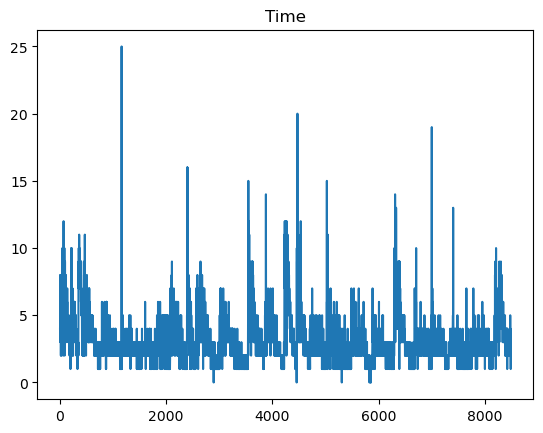

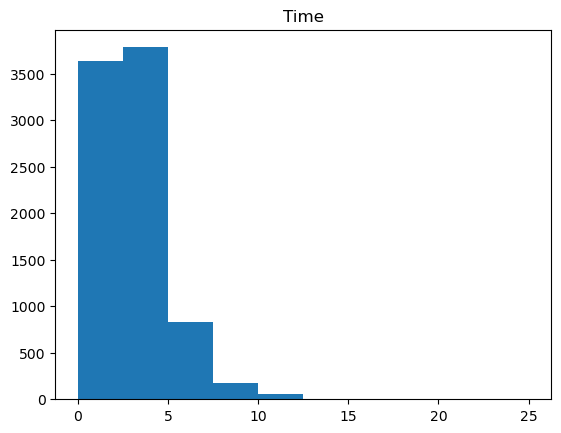

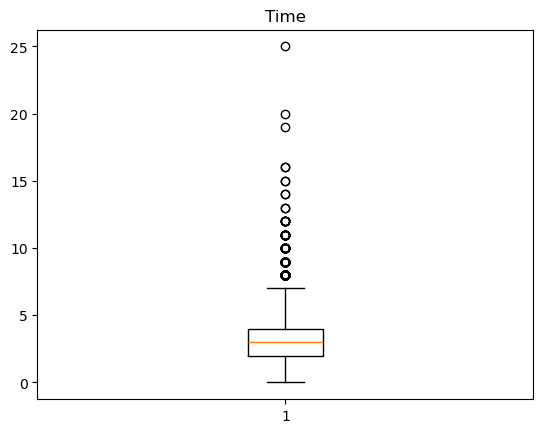

count    8494.000000
mean        3.059571
std         1.670766
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        25.000000
Name: Time, dtype: float64
0


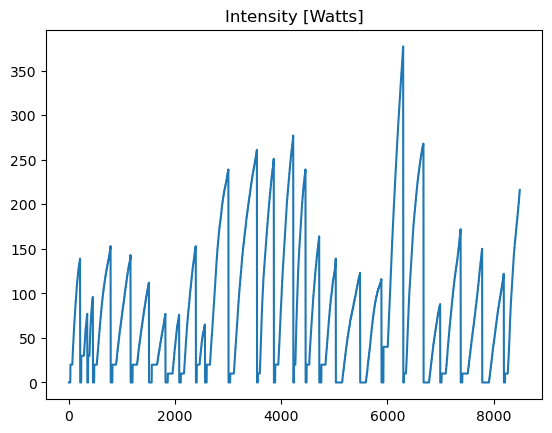

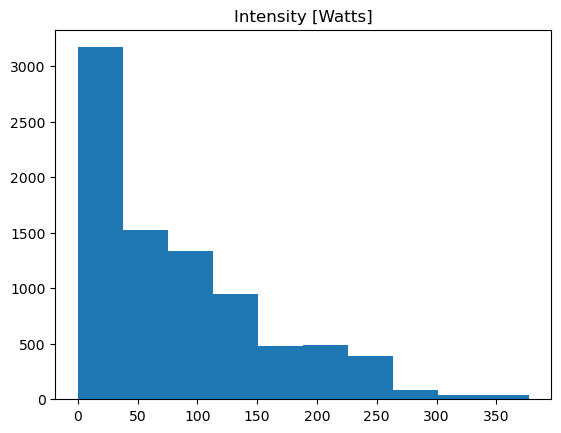

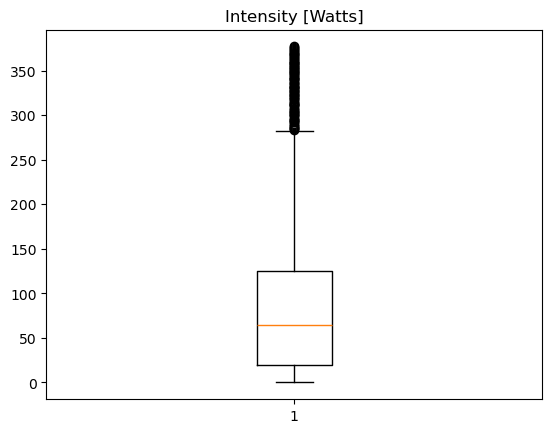

count    8494.000000
mean       82.527313
std        76.229866
min         0.000000
25%        20.000000
50%        64.000000
75%       125.000000
max       377.000000
Name: Intensity [Watts], dtype: float64
0


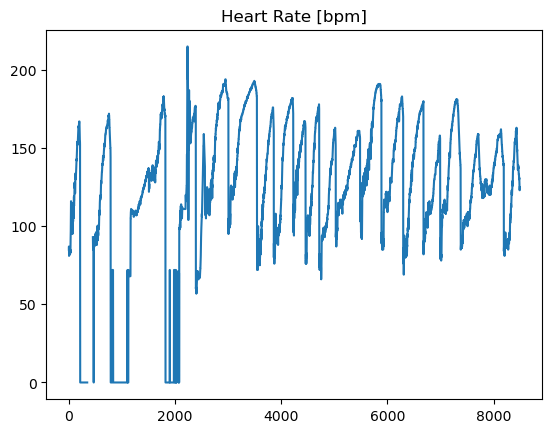

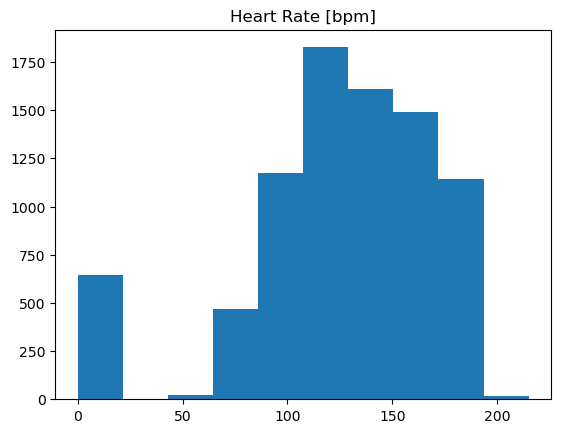

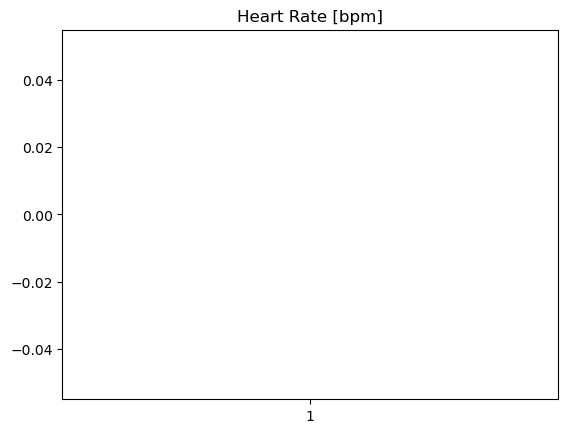

count    8388.000000
mean      123.813901
std        46.954012
min         0.000000
25%       104.000000
50%       129.000000
75%       158.000000
max       215.000000
Name: Heart Rate [bpm], dtype: float64
106


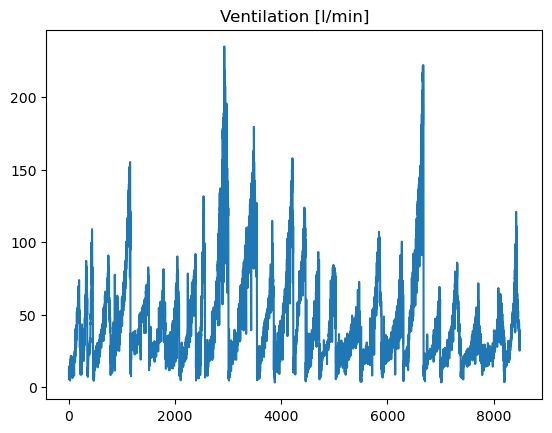

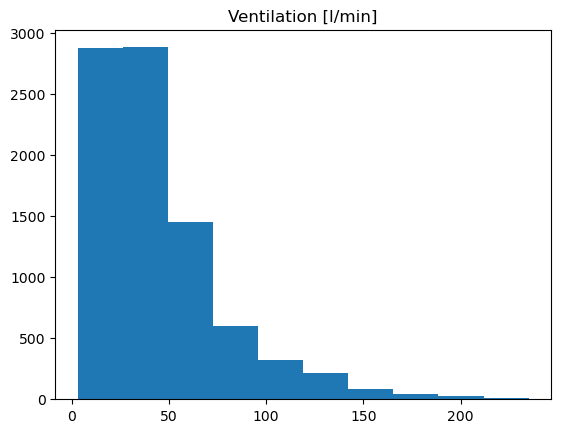

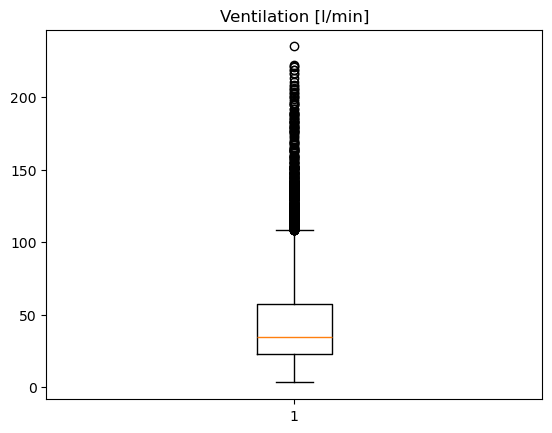

count    8494.000000
mean       45.074320
std        32.416695
min         3.127000
25%        23.003250
50%        34.480000
75%        57.065000
max       234.964000
Name: Ventilation [l/min], dtype: float64
0


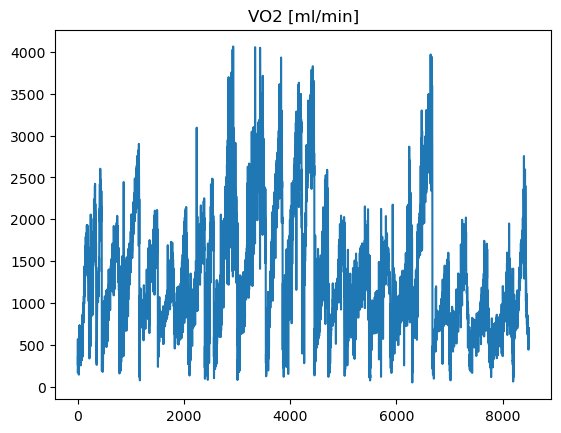

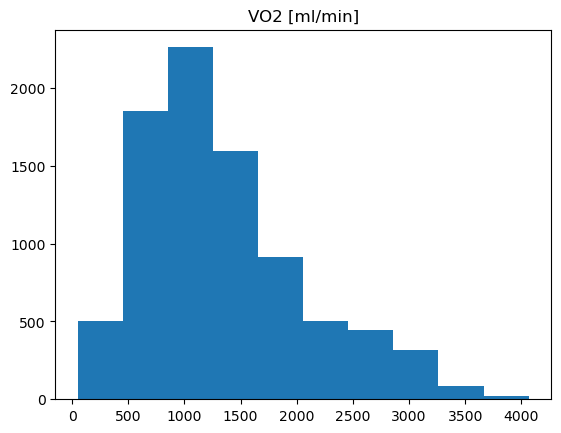

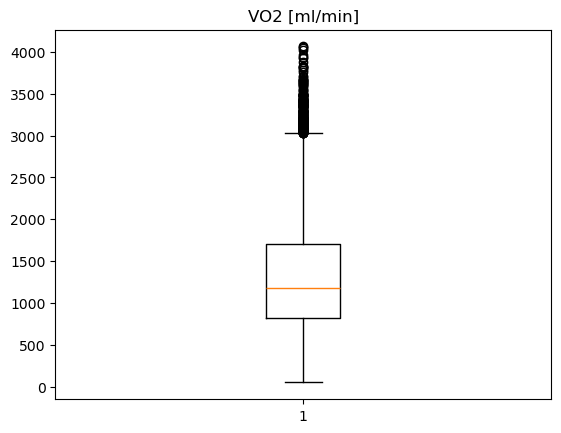

count    8494.000000
mean     1342.629606
std       721.715802
min        50.167745
25%       817.312312
50%      1175.583873
75%      1703.373725
max      4064.489063
Name: VO2 [ml/min], dtype: float64
0


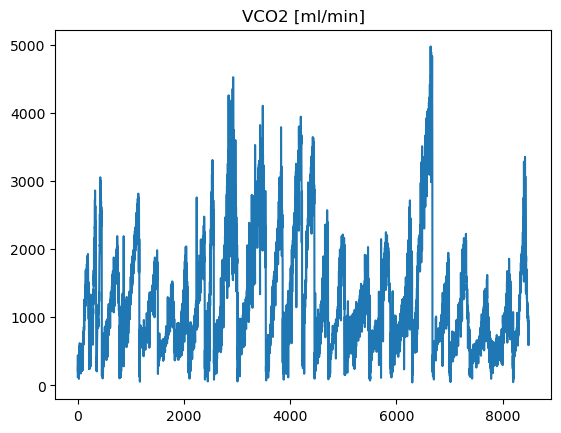

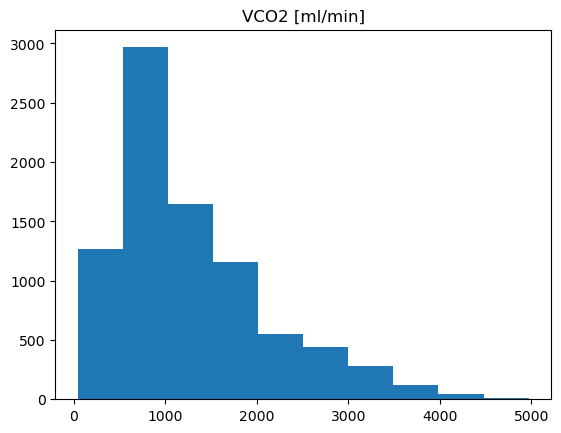

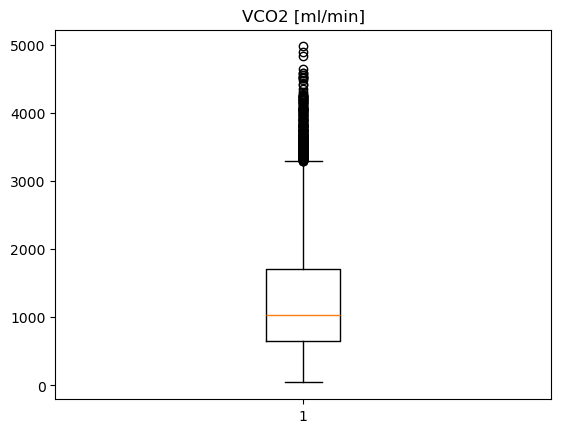

count    8494.000000
mean     1277.141493
std       840.084568
min        42.659301
25%       656.907030
50%      1030.893411
75%      1712.153010
max      4971.863163
Name: VCO2 [ml/min], dtype: float64
0


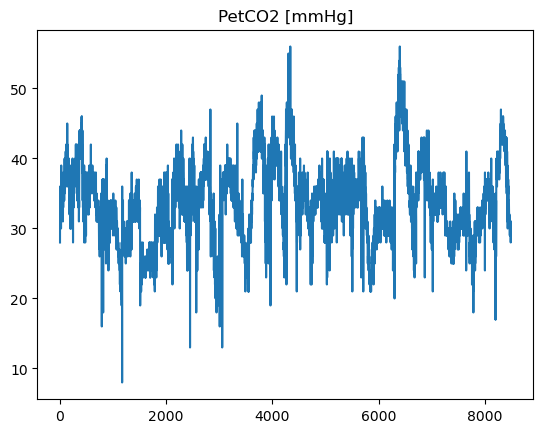

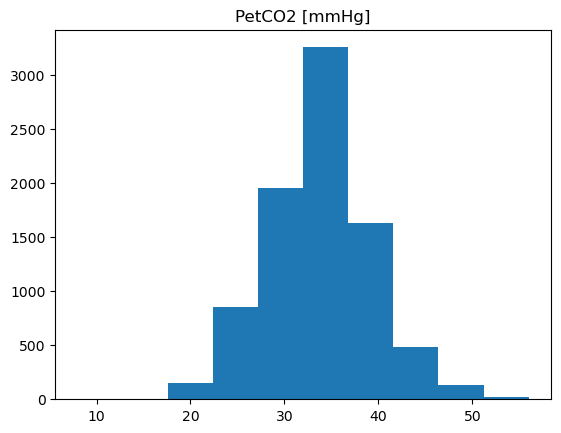

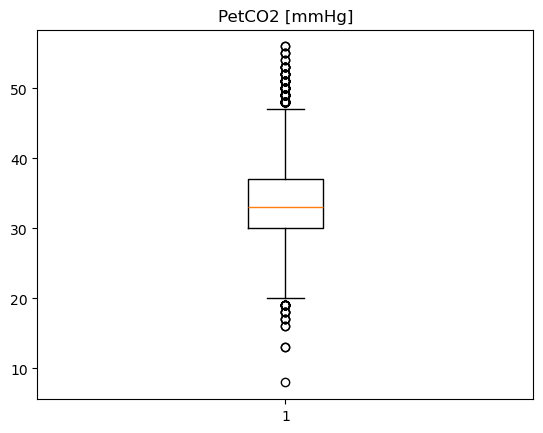

count    8494.000000
mean       33.597127
std         5.440118
min         8.000000
25%        30.000000
50%        33.000000
75%        37.000000
max        56.000000
Name: PetCO2 [mmHg], dtype: float64
0


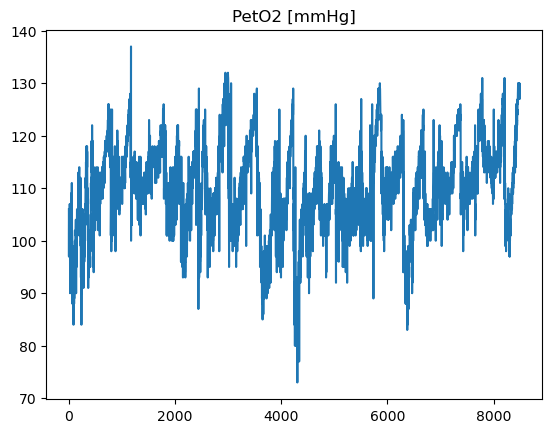

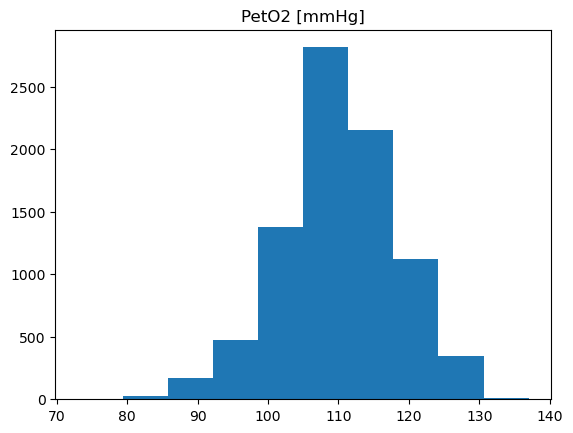

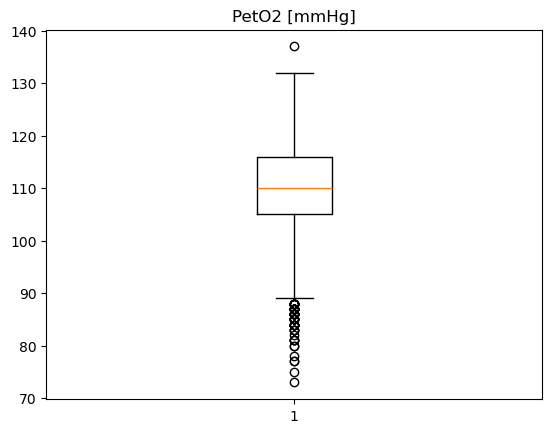

count    8494.000000
mean      110.056040
std         8.254741
min        73.000000
25%       105.000000
50%       110.000000
75%       116.000000
max       137.000000
Name: PetO2 [mmHg], dtype: float64
0


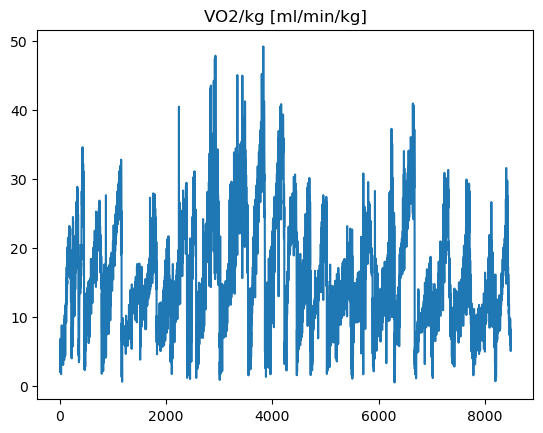

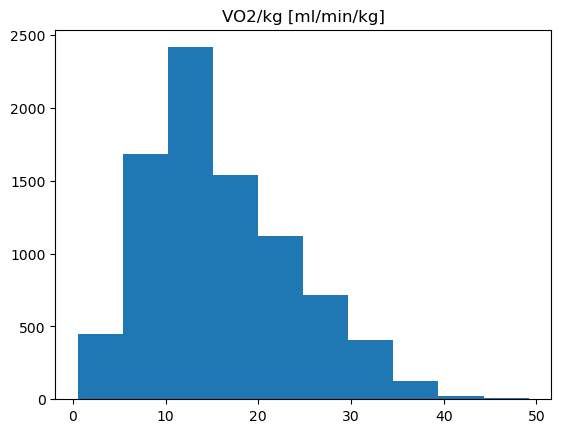

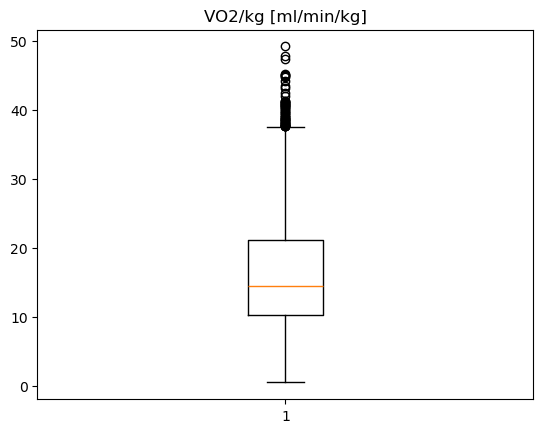

count    8494.000000
mean       16.037741
std         7.835723
min         0.520000
25%        10.232500
50%        14.425000
75%        21.147500
max        49.160000
Name: VO2/kg [ml/min/kg], dtype: float64
0


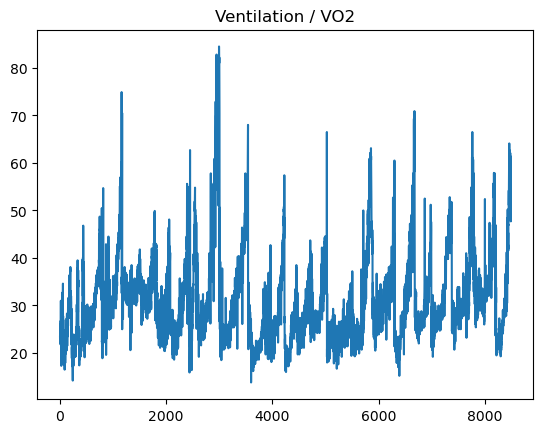

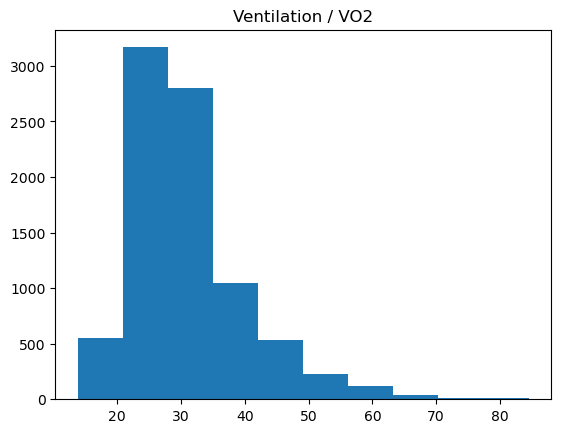

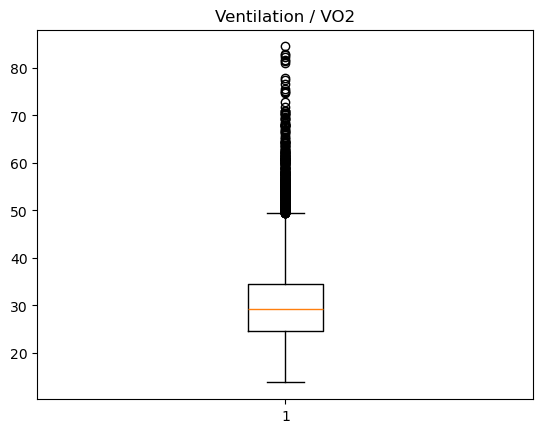

count    8494.000000
mean       30.936602
std         8.969780
min        13.800000
25%        24.700000
50%        29.200000
75%        34.600000
max        84.500000
Name: Ventilation / VO2, dtype: float64
0


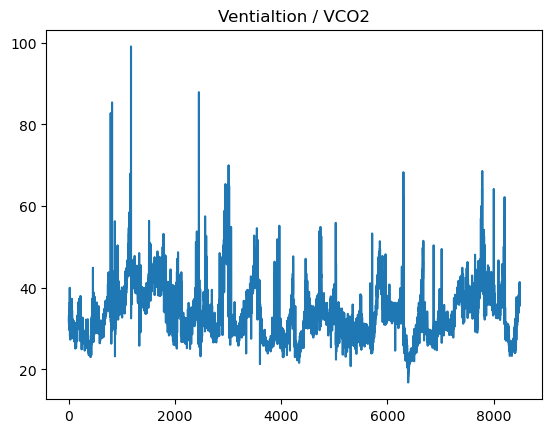

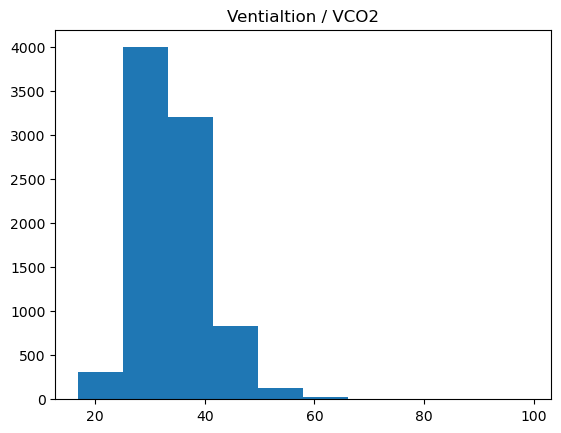

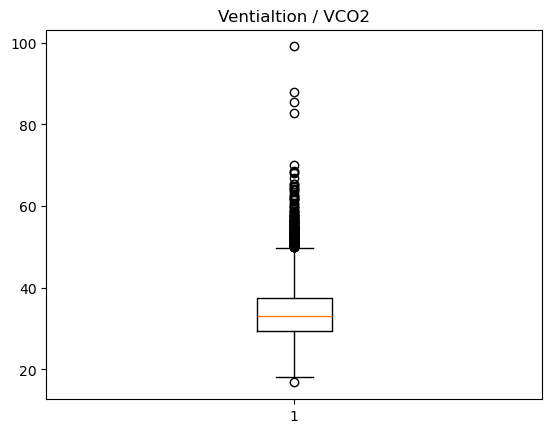

count    8494.000000
mean       34.023216
std         6.390045
min        16.800000
25%        29.400000
50%        33.150000
75%        37.600000
max        99.100000
Name: Ventialtion / VCO2, dtype: float64
0


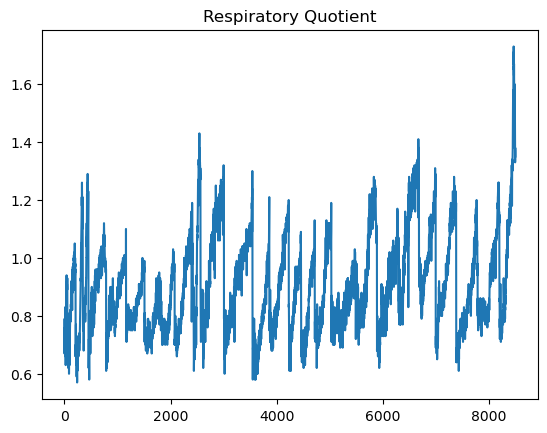

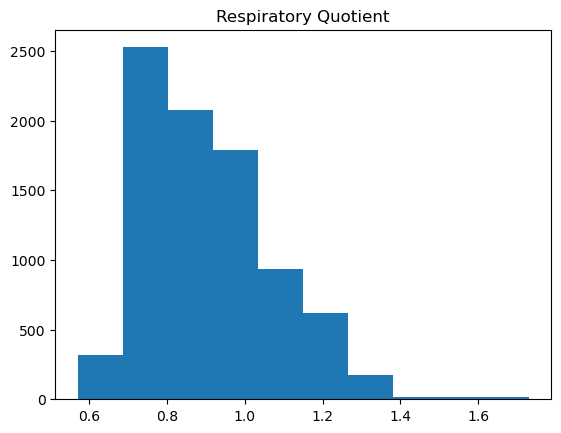

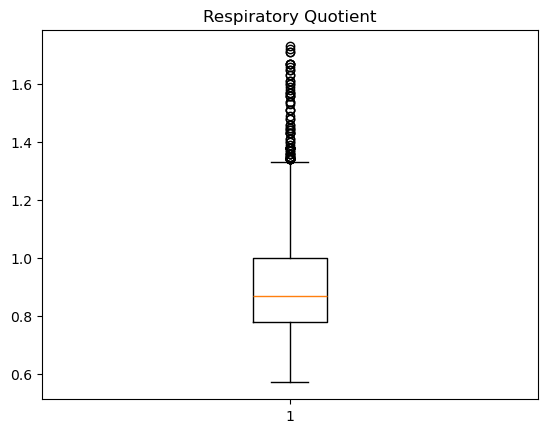

count    8494.000000
mean        0.905330
std         0.165748
min         0.570000
25%         0.780000
50%         0.870000
75%         1.000000
max         1.730000
Name: Respiratory Quotient, dtype: float64
0


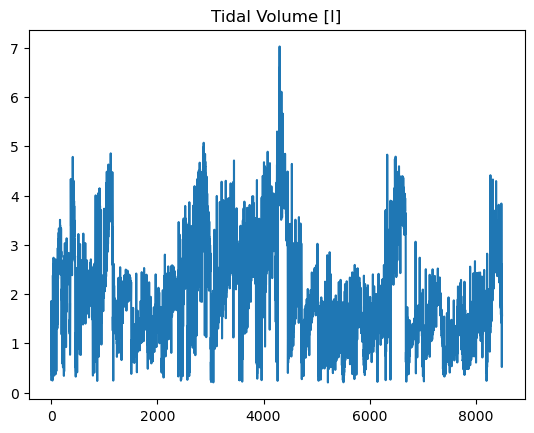

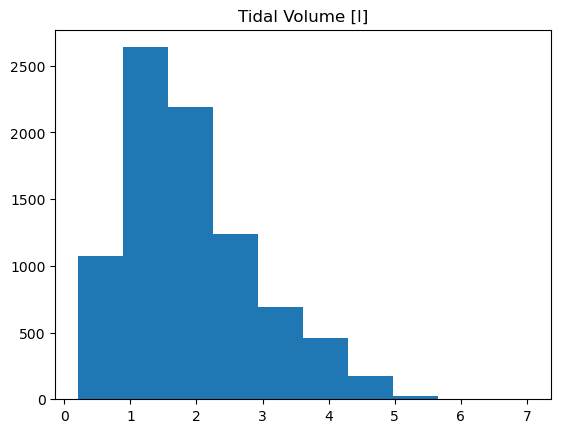

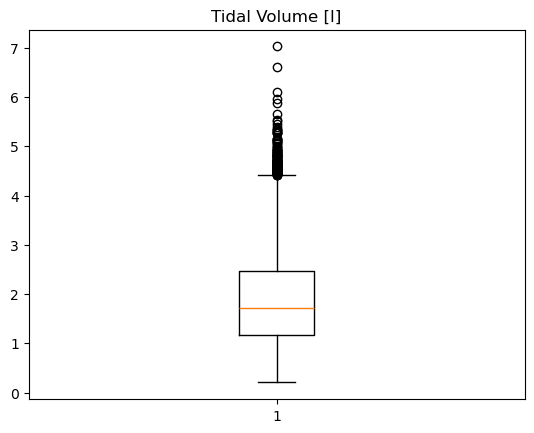

count    8494.000000
mean        1.912911
std         0.995636
min         0.204000
25%         1.159000
50%         1.707500
75%         2.460000
max         7.026000
Name: Tidal Volume [l], dtype: float64
0


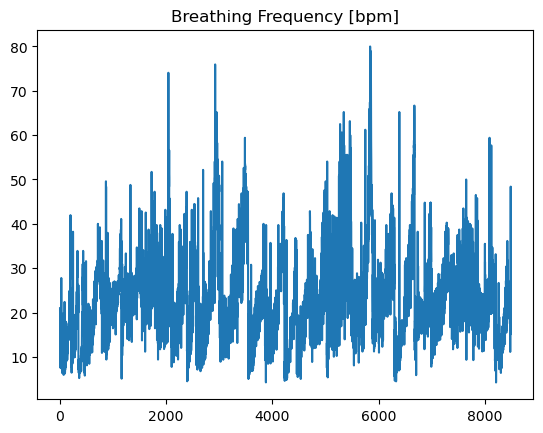

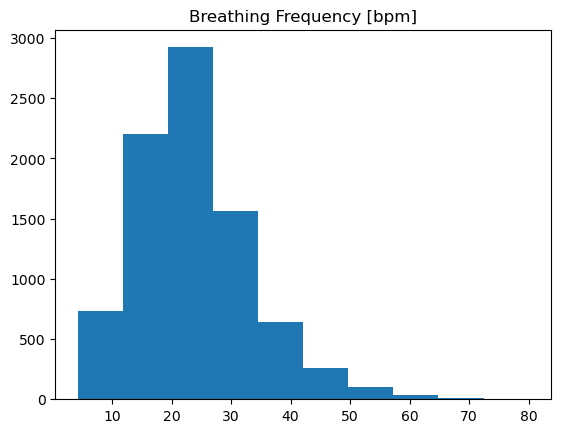

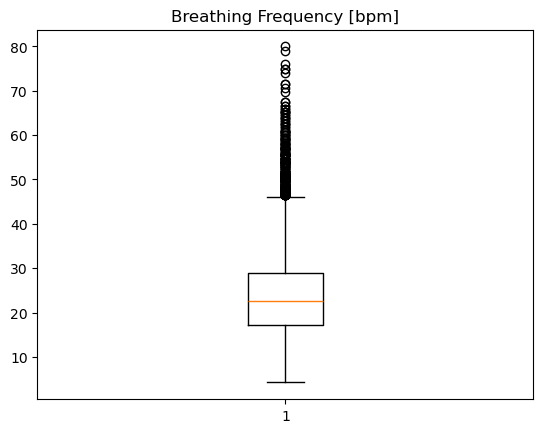

count    8494.000000
mean       23.782867
std         9.855425
min         4.220000
25%        17.140000
50%        22.560000
75%        28.850000
max        80.000000
Name: Breathing Frequency [bpm], dtype: float64
0


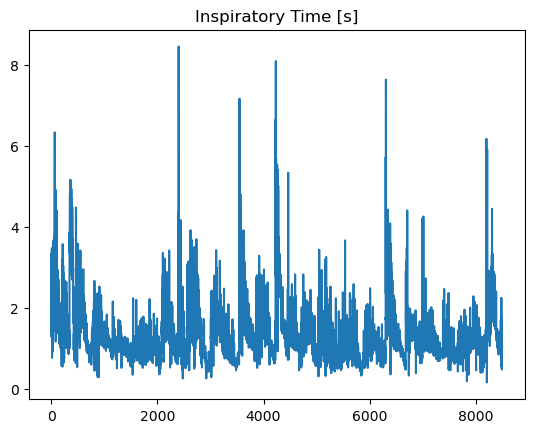

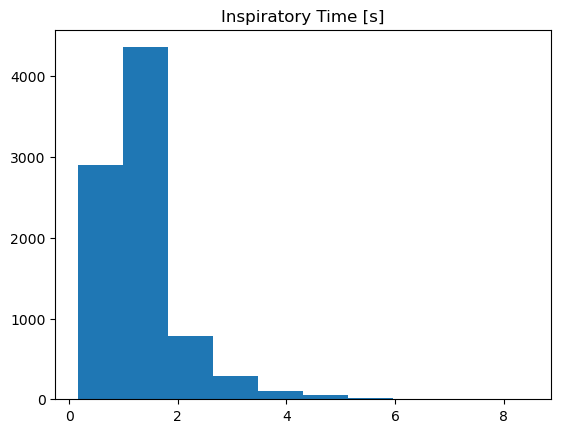

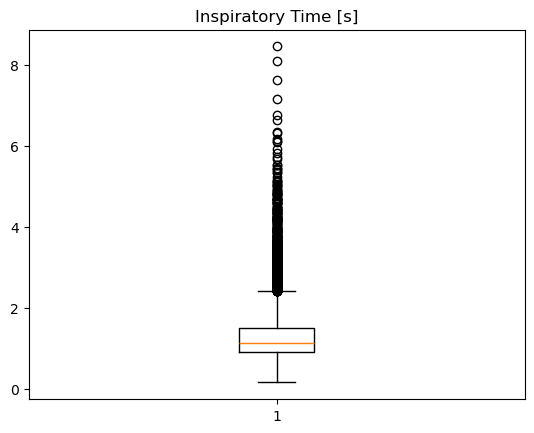

count    8494.000000
mean        1.333843
std         0.709169
min         0.160000
25%         0.910000
50%         1.140000
75%         1.510000
max         8.460000
Name: Inspiratory Time [s], dtype: float64
0


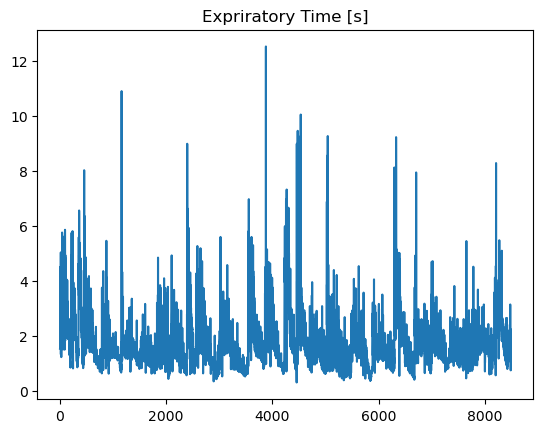

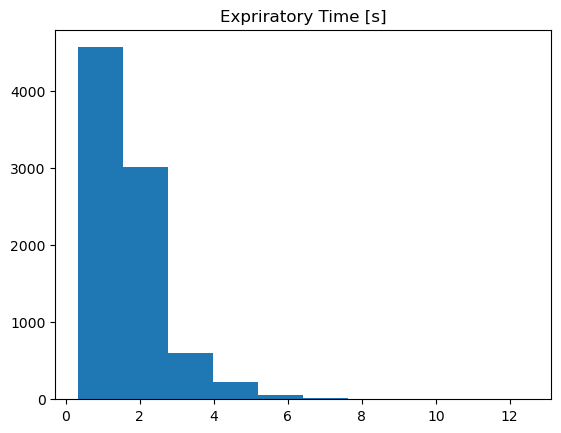

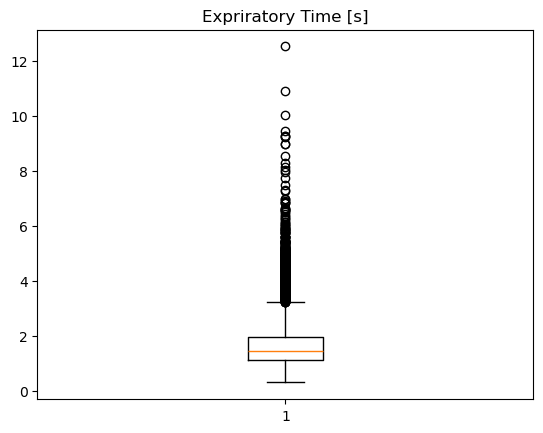

count    8494.000000
mean        1.711342
std         0.961148
min         0.320000
25%         1.120000
50%         1.480000
75%         1.970000
max        12.510000
Name: Expriratory Time [s], dtype: float64
0


In [24]:
def explory(data_dict, column):
    plt.figure(1)
    plt.plot(data_dict['data'][column])
    plt.title(column)
    plt.show()
    plt.figure(2)
    plt.hist(data_dict['data'][column])
    plt.title(column)
    plt.show()
    plt.figure(3)
    plt.boxplot(data_dict['data'][column])
    plt.title(column)
    plt.show()
    print(data_dict['data'][column].describe())
    print(data_dict['data'][column].isna().sum())

a =data['data'].columns
for i in a:
    explory(data, i)